<a href="https://colab.research.google.com/github/boskidisanalysis/titanic-preprocessing/blob/main/Preprocess_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
titanic = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [ ]:
titanic_features = titanic.copy()
titanic_labels = titanic_features.pop('survived')

In [ ]:
titanic_features.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


Creating Inputs

In [ ]:
inputs = {}

for name, column in titanic_features.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'age': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>,
 'alone': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'alone')>,
 'class': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'class')>,
 'deck': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'deck')>,
 'embark_town': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'embark_town')>,
 'fare': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'fare')>,
 'n_siblings_spouses': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'n_siblings_spouses')>,
 'parch': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'parch')>,
 'sex': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'sex')>}

Numerical Features

In [ ]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = layers.Normalization()
norm.adapt(np.array(titanic[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'normalization')>

In [ ]:
preprocessed_inputs = [all_numeric_inputs]

Categorical String Features

In [ ]:
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue

  lookup = layers.StringLookup(vocabulary=np.unique(titanic_features[name]))
  one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

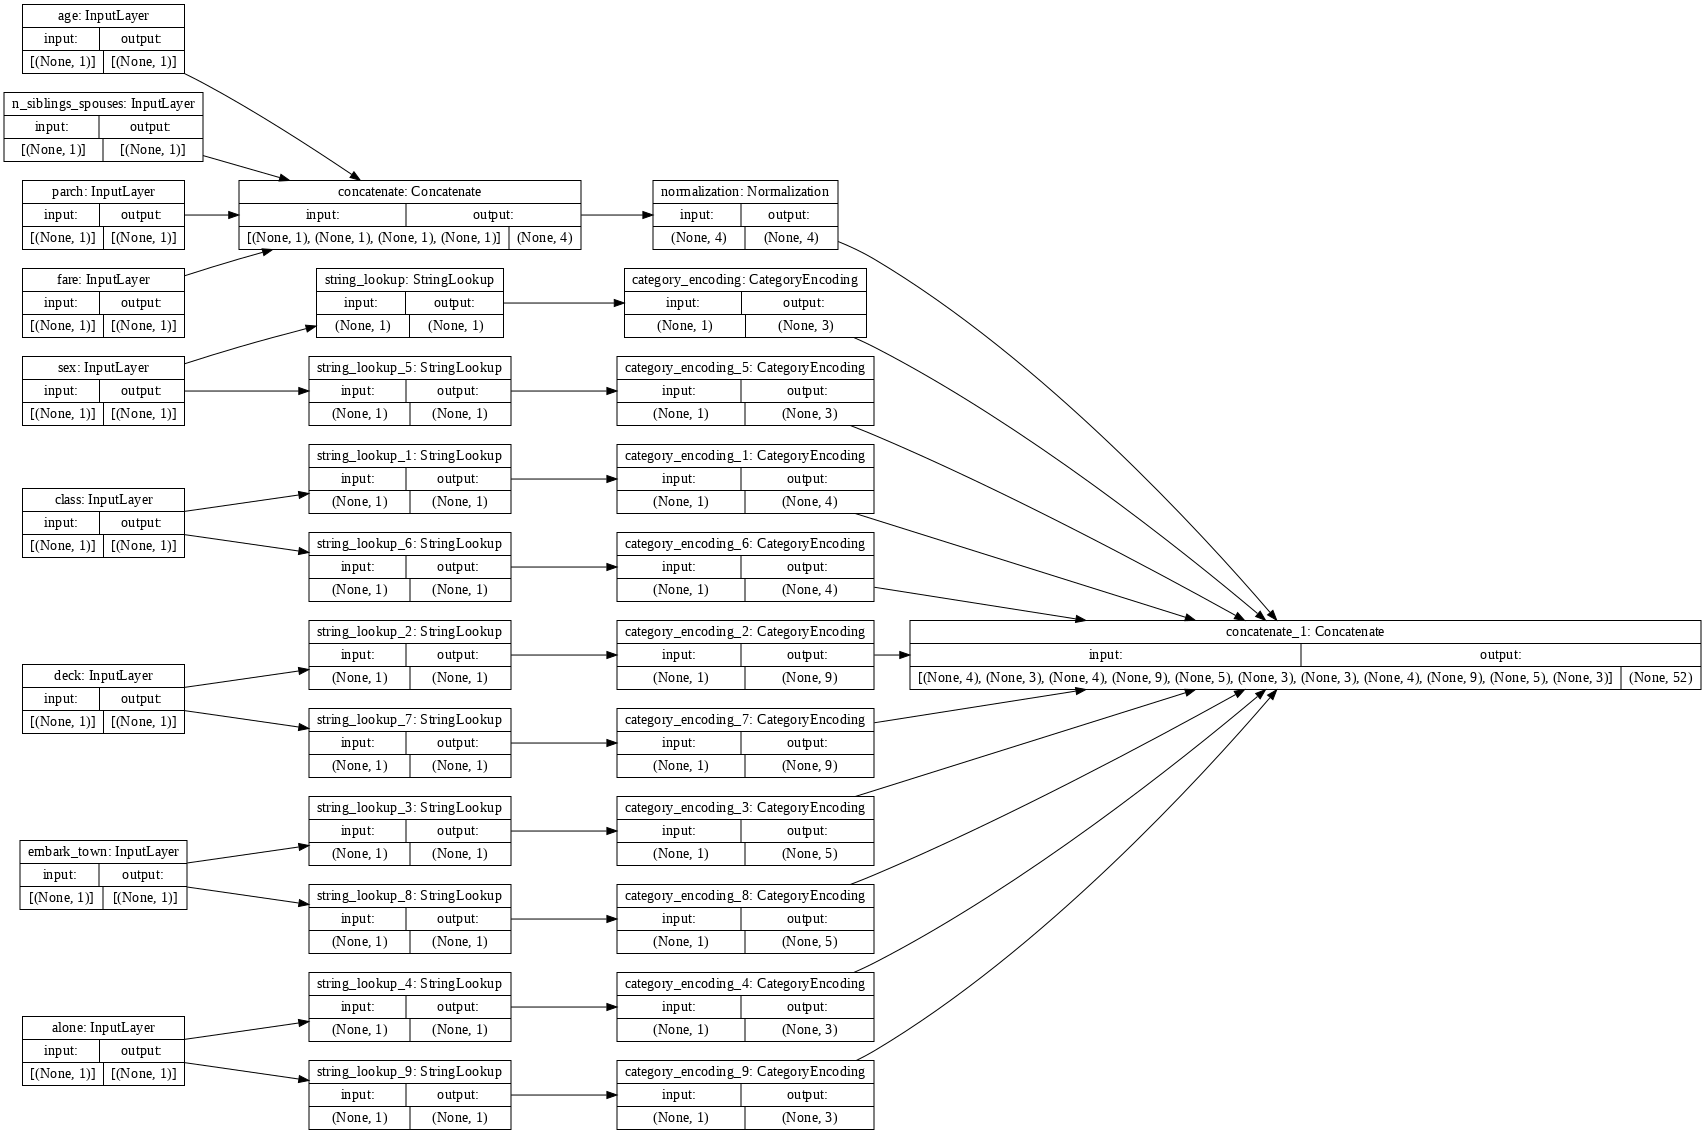

In [ ]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

titanic_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

tf.keras.utils.plot_model(model = titanic_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

In [ ]:
titanic_features_dict = {name: np.array(value) 
                         for name, value in titanic_features.items()}

In [ ]:
features_dict = {name:values[:1] for name, values in titanic_features_dict.items()}
titanic_preprocessing(features_dict)

<tf.Tensor: shape=(1, 52), dtype=float32, numpy=
array([[-0.610415 ,  0.395198 , -0.4790527, -0.4974028,  0.       ,
         0.       ,  1.       ,  0.       ,  0.       ,  0.       ,
         1.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  1.       ,
         0.       ,  0.       ,  0.       ,  1.       ,  0.       ,
         0.       ,  1.       ,  0.       ,  0.       ,  0.       ,
         1.       ,  0.       ,  0.       ,  0.       ,  1.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  1.       ,  0.       ,
         0.       ,  0.       ,  1.       ,  0.       ,  0.       ,
         1.       ,  0.       ]], dtype=float32)>

In [ ]:
def titanic_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(64),
    layers.Dense(1)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss=tf.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.optimizers.Adam())
  return model

titanic_model = titanic_model(titanic_preprocessing, inputs)

In [ ]:
titanic_model.fit(x=titanic_features_dict, y=titanic_labels, epochs=10)

Epoch 1/10
20/20 [==============================] - 1s 3ms/step - loss: 0.5671
Epoch 2/10
20/20 [==============================] - 0s 2ms/step - loss: 0.4787
Epoch 3/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4477
Epoch 4/10
20/20 [==============================] - 0s 2ms/step - loss: 0.4331
Epoch 5/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4275
Epoch 6/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4288
Epoch 7/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4231
Epoch 8/10
20/20 [==============================] - 0s 2ms/step - loss: 0.4222
Epoch 9/10
20/20 [==============================] - 0s 2ms/step - loss: 0.4217
Epoch 10/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4208
